In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import random 
import copy
from itertools import compress
from itertools import groupby
import scipy.optimize as opt
import time
import matplotlib
import pickle

In [2]:
def system2_ODEs(t,z,params):
    a, b = z
    kdA, kdB, gammaAK, gammaBK, gammaAP, gammaBP, Atot, Btot, F = params
    
    sa = np.sqrt(1 + 2*a)
    sb = np.sqrt(1 + 2*b)
    
    k = a**2 / ((1 + sa) * (1 + a + sa))
    p = b**2 / ((1 + sb) * (1 + b + sb))
    f_p = (F + kdB * p)
    
    dadt = -2 * gammaAK * a / (1 + sa) * kdA * k + gammaAP * (2 * Atot / kdA - a) * f_p
    dbdt = -2 * gammaBK * b / (1 + sb) * kdA * k + gammaBP * (2 * Btot / kdB - b) * f_p
    
    dzdt = [dadt, dbdt]
    return(dzdt)

In [3]:
def system2_Jac(t,z,params):
    kdA, kdB, gammaAK, gammaBK, gammaAP, gammaBP, Atot, Btot, F = params
    a, b = z
    
    sa = np.sqrt(1 + 2*a)
    sb = np.sqrt(1 + 2*b)
    
    jac = np.array([[(a**2*(-1 - 2/sa)*kdA*gammaAK)/(1 + a + sa)**2 - F*gammaAP - 
                     (b**2*kdB*gammaAP)/((1 + sb)*(1 + b + sb)),
                     (b*(4*(1 + sb) + b*(7 + b + 3*sb))*(2*Atot - a*kdA)*kdB*gammaAP)/
                     (sb*(1 + sb)**2*(1 + b + sb)**2*kdA)],
    [(-2*a*(4*(1 + sa) + a*(7 + a + 3*sa))*b*kdA*gammaBK)/
     (sa*(1 + sa)**2*(1 + a + sa)**2*(1 + sb)),
     (-4*a*b*Btot*gammaBP + 4*a*(-1 + sb)*Btot*gammaBP - 3*a*b**3*kdB*gammaBP + 
      b**2*((2 + 3*a - 2*sa - a*sa)*kdA*gammaBK + a*(2*Btot - 3*kdB + sb*(-2*F + 3*kdB))*gammaBP))/
      (2.*a*b**2*sb)]])
        
    return jac

In [4]:
def system2_Sol(tSpan, params, initialConditions, toPlot, plotLog=False, atol=1e-12, rtol=1e-6):
    odeSol = scipy.integrate.solve_ivp(lambda tSpan, z: system2_ODEs(tSpan, z, params),
                                        tSpan,initialConditions,method = 'Radau', vectorized=False,
                                        jac = lambda tSpan,z: system2_Jac(tSpan,z,params),
                                        atol=atol, rtol=rtol)
    z = np.transpose(odeSol.y)
    t = odeSol.t
    
    if toPlot:
        system2_Plot_for_fig(t, z, params, initialConditions, plotLog=plotLog)
    return z,t

In [5]:
def system2_Plot_for_fig(t, z, params, initialConditions, plotLog=False):
    
    tHr = t / (60*60)  # so time is measured in hours
    lenTStart = 0 #int(len(z[:,0])/10)

    kdA, kdB, gammaAK, gammaBK, gammaAP, gammaBP, Atot, Btot, F = params
    a = z[:,0]
    b = z[:,1]
    
    Ap = Atot - (kdA / 2) * a
    Bp = Btot - (kdB / 2) * b
    
    plt.plot(tHr[lenTStart:], Ap[lenTStart:] + Bp[lenTStart:], 'b', label=r'$A^p$')
    plt.ylabel(r'Total phosphorylation ($\mu$M)')
    plt.xlabel('Time (h)')
    if plotLog:
        plt.yscale('log')
    if kdA == 0.0017365224716919757:
        plt.ylim([1, 5])
        plt.yticks([1, 3, 5])
    plt.show()

In [6]:
def save(obj, filename):
# =============================================================================
#     Save an object to a file
# =============================================================================
    if not filename[-7:] == '.pickle':
        filename = filename + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=4) #protocol 4 came out with Python version 3.4


def load(filename):
# =============================================================================
#     Load an object from a file
# =============================================================================
    if not filename[-7:] == '.pickle':
        filename = filename + '.pickle'
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

(oscParamsAll, oscMaxFAll, oscKdAAll, oscKdBAll, oscPeriodsAll, nonOscParamsAll, 
 nonOscMaxFAll, nonOscKdAAll, nonOscKdBAll) = load(
         'sys2_no_approx_500000.pickle')

oscParams = oscParamsAll
periods = oscPeriodsAll
# Each parameter set consists of:
# kdA, kdB, gammaAK, gammaBK, gammaAP, gammaBP, Atot, Btot, F = params

In [7]:
# Initialize amplitude arrays
num_osc = len(oscParams)
KA_array = np.zeros(num_osc)
PA_array = np.zeros(num_osc)
kA_array = np.zeros(num_osc)
pA_array = np.zeros(num_osc)
kpA_array = np.zeros(num_osc)
ppA_array = np.zeros(num_osc)
kmA_array = np.zeros(num_osc)
pmA_array = np.zeros(num_osc)

alist = [None for _ in range(num_osc)]
blist = [None for _ in range(num_osc)]

In [8]:
alist = load('unbounded_kinase_a_integration.pickle')
blist = load('unbounded_phosphatase_b_integration.pickle')


In [9]:
def amplitude_fxn(arr):
    # Given an array of concentrations, arr, calculate the amplitude
    return(max(arr) / min(arr))

In [10]:
num_periods_to_integrate = 12

start = time.time()
for e, params in enumerate(oscParams):
    if e % 100 == 0:
        print('Starting parameter set number ' + str(e) + ' out of ' + str(num_osc) + 
              '; time elapsed = ' + str(time.time() - start))
    
    period = periods[e]
    kdA, kdB, gammaAK, gammaBK, gammaAP, gammaBP, Atot, Btot, F = params    
    initialConditions = [2 * Atot / kdA, 2 * Btot / kdB]
    
    atol = 1e-16
    rtol = 2.3e-14
    
    min_k = -1
    min_kp = -1
    min_K = -1
    negK = False
    
    while min_k < 0 or min_kp < 0 or min_K < 0:
        if alist[e] is None or negK:
            z,t = system2_Sol([0, num_periods_to_integrate * period],
                              params, initialConditions, False, False, atol=1e-16, rtol=1e-14)
            ti = np.abs(t - (num_periods_to_integrate-1) * period).argmin()  # index of t one period from the end

            a = z[ti:,0]  # kinase multimer value over one period
            b = z[ti:,1]  # phosphatase multimer value over one period
        
        else:
            a = alist[e]
            b = blist[e]

        sa = np.sqrt(1 + 2*a)
        sb = np.sqrt(1 + 2*b)
        
        K = kdA * a**2 / ((1 + sa) * (1 + a + sa))
        P = kdB * b**2 / ((1 + sb) * (1 + b + sb))
        
        kp = Atot - kdA * a / 2
        pp = Btot - kdB * b / 2

        k = Atot - kp - K
        p = Btot - pp - P
        
        km = k + kp
        pm = p + pp
        
        min_K = min(K)
        min_k = min(k)
        min_kp = min(kp)
        if min_k < 0 or min_kp < 0 or min_K < 0:
            negK = True
        
        atol /= 10
        rtol /= 10
    
#     print(min(K))
#     print(min(k))
#     print(min(kp))
    
    # Measure amplitudes
    
    # If multimers fluoresce and monomers don't
    KA = amplitude_fxn(K)
    PA = amplitude_fxn(P)
    
    # If unphosphorylated monomers fluoresce and others don't
    kA = amplitude_fxn(k)
    pA = amplitude_fxn(p)
    
    # If monomers fluoresce when phosphorylated
    kpA = amplitude_fxn(kp)
    ppA = amplitude_fxn(pp)
    
    # If all monomers and multimers don't
    kmA = amplitude_fxn(km)
    pmA = amplitude_fxn(pm)

    KA_array[e] = KA
    PA_array[e] = PA
    kA_array[e] = kA
    pA_array[e] = pA
    kpA_array[e] = kpA
    ppA_array[e] = ppA
    kmA_array[e] = kmA
    pmA_array[e] = pmA

    alist[e] = a
    blist[e] = b
    

Starting parameter set number 0 out of 711; time elapsed = 0.00043702125549316406
Starting parameter set number 10 out of 711; time elapsed = 0.22789502143859863
Starting parameter set number 20 out of 711; time elapsed = 0.42527198791503906
Starting parameter set number 30 out of 711; time elapsed = 0.6687469482421875
Starting parameter set number 40 out of 711; time elapsed = 0.8745248317718506
Starting parameter set number 50 out of 711; time elapsed = 1.0727128982543945
Starting parameter set number 60 out of 711; time elapsed = 1.3007748126983643
Starting parameter set number 70 out of 711; time elapsed = 1.520702838897705
Starting parameter set number 80 out of 711; time elapsed = 1.728943109512329
Starting parameter set number 90 out of 711; time elapsed = 1.973073959350586
Starting parameter set number 100 out of 711; time elapsed = 2.154265880584717
Starting parameter set number 110 out of 711; time elapsed = 2.362269878387451
Starting parameter set number 120 out of 711; time

In [16]:
# save(alist, 'unbounded_kinase_a_integration.pickle')
# save(blist, 'unbounded_phosphatase_b_integration.pickle')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


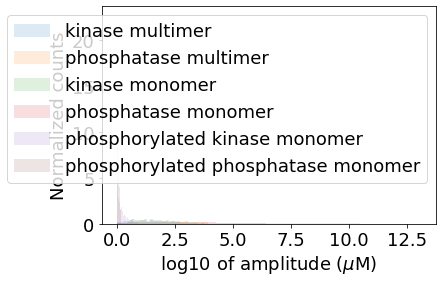

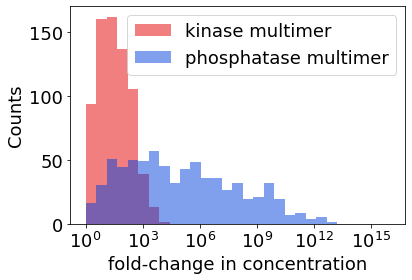

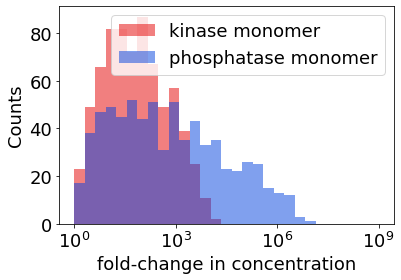

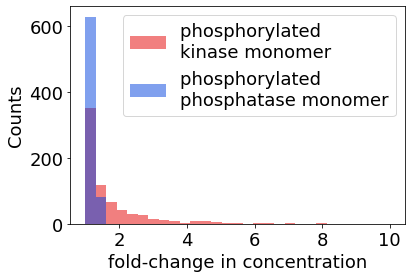

In [11]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure()
plt.hist(np.log10(KA_array), 30, density=True, label='kinase multimer', alpha=0.15)
plt.hist(np.log10(PA_array), 30, density=True, label='phosphatase multimer', alpha=0.15)
plt.hist(np.log10(kA_array), 30, density=True, label='kinase monomer', alpha=0.15)
plt.hist(np.log10(pA_array), 30, density=True, label='phosphatase monomer', alpha=0.15)
plt.hist(np.log10(kpA_array), 30, density=True, label='phosphorylated kinase monomer', alpha=0.15)
plt.hist(np.log10(ppA_array), 30, density=True, label='phosphorylated phosphatase monomer', alpha=0.15)
plt.xlabel('log10 of amplitude ($\mu$M)')
plt.ylabel('Normalized counts')
plt.legend()
plt.show()

plt.figure()
plt.hist(KA_array, np.logspace(0, 16, 30), density=False, 
         label='kinase multimer', alpha=0.5, color='xkcd:red')
plt.hist(PA_array, np.logspace(0, 16, 30), density=False, 
         label='phosphatase multimer', alpha=0.5, color='xkcd:blue')
plt.xlabel('fold-change in concentration')
plt.ylabel('Counts')
plt.xscale('log')
plt.xticks([1e0, 1e3, 1e6, 1e9, 1e12, 1e15])
plt.legend()
plt.show()

plt.figure()
plt.hist(kA_array, np.logspace(0, 9, 30), density=False, 
         label='kinase monomer', alpha=0.5, color='xkcd:red')
plt.hist(pA_array, np.logspace(0, 9, 30), density=False, 
         label='phosphatase monomer', alpha=0.5, color='xkcd:blue')
plt.xlabel('fold-change in concentration')
plt.ylabel('Counts')
plt.xscale('log')
plt.xticks([1e0, 1e3, 1e6, 1e9])
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.hist(kpA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nkinase monomer', alpha=0.5, color='xkcd:red')
plt.hist(ppA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nphosphatase monomer', alpha=0.5, color='xkcd:blue')
plt.xlabel('fold-change in concentration')
plt.ylabel('Counts')
plt.legend()
plt.show()


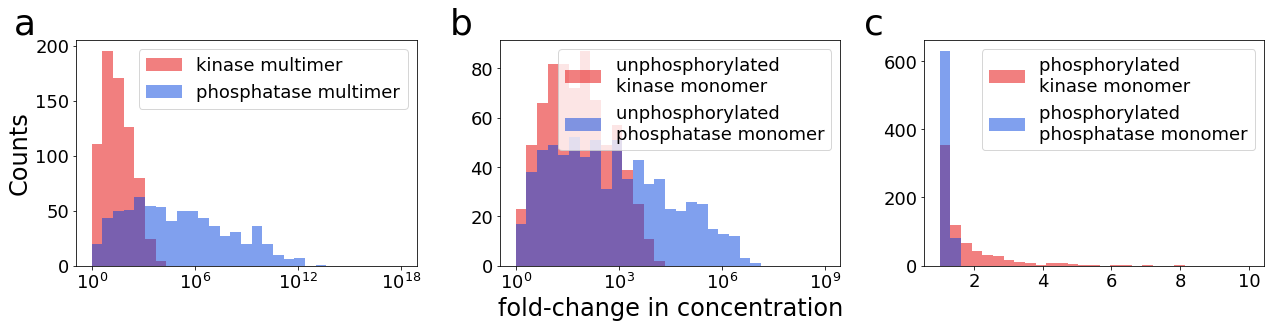

In [14]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

axs[0].hist(KA_array, bins=np.logspace(0, 18, 30), density=False, 
         label='kinase multimer', alpha=0.5, color='xkcd:red')
axs[0].hist(PA_array, np.logspace(0, 18, 30), density=False, 
         label='phosphatase multimer', alpha=0.5, color='xkcd:blue')
# plt.xlabel('fold-change in concentration')
axs[0].set_ylabel('Counts', fontsize=24)
axs[0].set_xscale('log')
axs[0].set_xticks([1e0, 1e6, 1e12, 1e18])
axs[0].legend()
axs[0].text(-0.12, 1.15, 'a', transform=axs[0].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')


axs[1].hist(kA_array, bins=np.logspace(0, 9, 30), density=False, 
         label='unphosphorylated \nkinase monomer', alpha=0.5, color='xkcd:red')
axs[1].hist(pA_array, np.logspace(0, 9, 30), density=False, 
         label='unphosphorylated \nphosphatase monomer', alpha=0.5, color='xkcd:blue')
axs[1].set_xlabel('fold-change in concentration', fontsize=24)
# plt.ylabel('Counts')
axs[1].set_xscale('log')
axs[1].set_xticks([1e0, 1e3, 1e6, 1e9])
axs[1].legend(loc='upper right')
axs[1].text(-0.08, 1.15, 'b', transform=axs[1].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')

axs[2].hist(kpA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nkinase monomer', alpha=0.5, color='xkcd:red')
axs[2].hist(ppA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nphosphatase monomer', alpha=0.5, color='xkcd:blue')
# plt.xlabel('fold-change in concentration')
# plt.ylabel('Counts')
axs[2].legend()
axs[2].text(-0.12, 1.15, 'c', transform=axs[2].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')

plt.tight_layout(h_pad=0, w_pad=0.2)
# plt.savefig('amplitude_fold_change_unbounded.png', 
#             dpi=800, bbox_inches='tight')
# plt.savefig('amplitude_fold_change_unbounded_small.png', 
#             bbox_inches='tight')
plt.show()

In [79]:
max(ppA_array)

1.580531441314638

In [81]:
np.log10(max(PA_array))

13.109774488880682

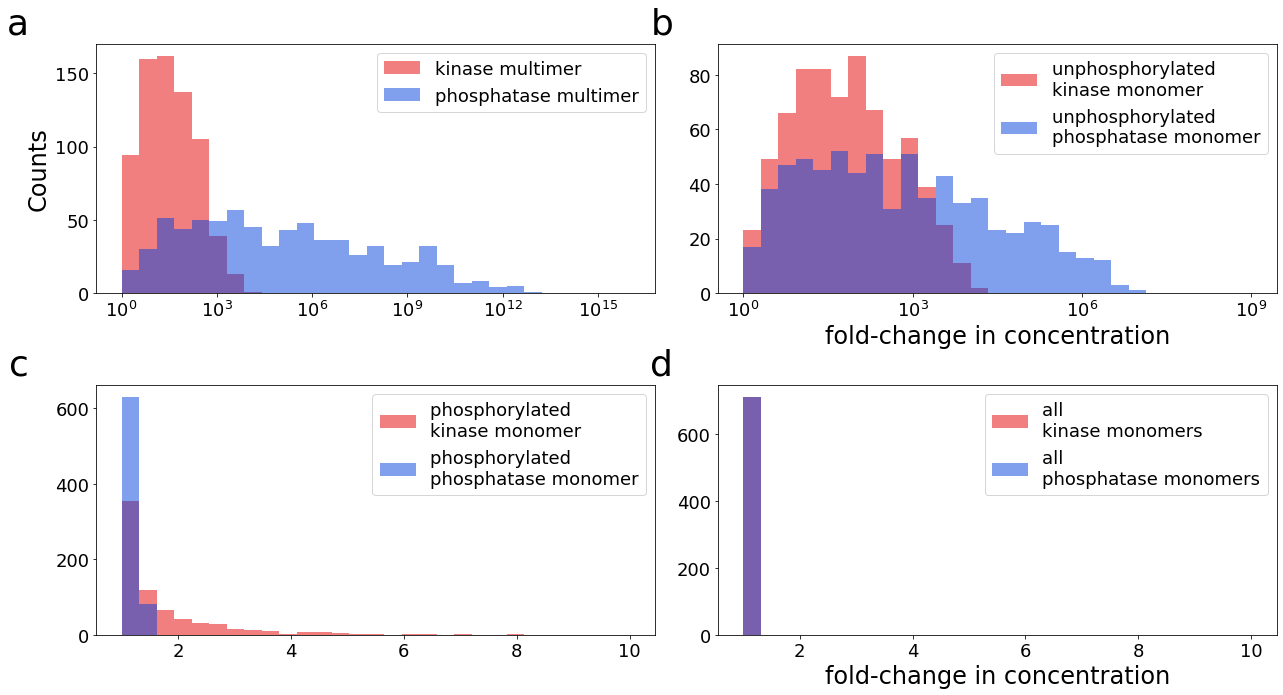

In [13]:
fig, axs = plt.subplots(2,2, figsize=(18,10))

axs[0,0].hist(KA_array, bins=np.logspace(0, 16, 30), density=False, 
         label='kinase multimer', alpha=0.5, color='xkcd:red')
axs[0,0].hist(PA_array, np.logspace(0, 16, 30), density=False, 
         label='phosphatase multimer', alpha=0.5, color='xkcd:blue')
# plt.xlabel('fold-change in concentration')
axs[0,0].set_ylabel('Counts', fontsize=24)
axs[0,0].set_xscale('log')
axs[0,0].set_xticks([1e0, 1e3, 1e6, 1e9, 1e12, 1e15])
axs[0,0].legend()
axs[0,0].text(-0.12, 1.15, 'a', transform=axs[0,0].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')


axs[0,1].hist(kA_array, bins=np.logspace(0, 9, 30), density=False, 
         label='unphosphorylated \nkinase monomer', alpha=0.5, color='xkcd:red')
axs[0,1].hist(pA_array, np.logspace(0, 9, 30), density=False, 
         label='unphosphorylated \nphosphatase monomer', alpha=0.5, color='xkcd:blue')
axs[0,1].set_xlabel('fold-change in concentration', fontsize=24)
# plt.ylabel('Counts')
axs[0,1].set_xscale('log')
axs[0,1].set_xticks([1e0, 1e3, 1e6, 1e9])
axs[0,1].legend(loc='upper right')
axs[0,1].text(-0.08, 1.15, 'b', transform=axs[0,1].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')

axs[1,0].hist(kpA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nkinase monomer', alpha=0.5, color='xkcd:red')
axs[1,0].hist(ppA_array, np.linspace(1, 10, 30), density=False, 
         label='phosphorylated \nphosphatase monomer', alpha=0.5, color='xkcd:blue')
# plt.xlabel('fold-change in concentration')
# plt.ylabel('Counts')
axs[1,0].legend()
axs[1,0].text(-0.12, 1.15, 'c', transform=axs[1,0].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')

axs[1,1].hist(kmA_array, np.linspace(1, 10, 30), density=False, 
         label='all \nkinase monomers', alpha=0.5, color='xkcd:red')
axs[1,1].hist(pmA_array, np.linspace(1, 10, 30), density=False, 
         label='all \nphosphatase monomers', alpha=0.5, color='xkcd:blue')
axs[1,1].set_xlabel('fold-change in concentration', fontsize=24)
# plt.ylabel('Counts')
# axs[1,1].set_xscale('log')
# axs[1,1].set_xticks([1e0, 1e3, 1e6, 1e9])
axs[1,1].legend(loc='upper right')
axs[1,1].text(-0.08, 1.15, 'd', transform=axs[1,1].transAxes,
  fontsize=36, fontweight='normal', va='top', ha='right')

plt.tight_layout(h_pad=0, w_pad=0.2)
# plt.savefig('amplitude_fold_change_unbounded_2.png', 
#             dpi=800, bbox_inches='tight')
plt.show()